<a href="https://colab.research.google.com/github/develly/Image-Classifier-Caltech101/blob/main/Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.10


In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 52kB/s 
     |████████████████████████████████| 460kB 43.8MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


In [ ]:
!nvidia-smi

Tue May 11 04:51:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |   1248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [9]:
!ls "/drive/MyDrive/Dataset"

caltech101


# 이미지 분류기 생성

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # rgb를 0~1 값으로 변경, train : val = 8:2

In [ ]:
batch_size = 16
input_image_size = (200, 200)

# train data 준비
train_generator = train_datagen.flow_from_directory(
    '/drive/My Drive/Dataset/caltech101',
    target_size=input_image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
) 
# class_mode : 총 101개의 종류 분류로 binary가 아닌 categorical

Found 7006 images belonging to 101 classes.


In [ ]:
# validation data 준비
validation_generator = train_datagen.flow_from_directory(
    '/drive/My Drive/Dataset/caltech101',
    target_size=input_image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
) 
# class_mode : 총 101개의 종류 분류로 binary가 아닌 categorical

Found 1700 images belonging to 101 classes.


In [ ]:
# CNN 모델 구축
from keras.layers import Dense, Input, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model, Sequential

# 필터수 32, 커널의 행/열, input_shape rgb 3차원 (3x3 이 32개, 필터마다 고유한 특징을 뽑아서 고유한 출력 이미지 생성함)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024)) # 출력 뉴런의 수
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(101))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)            

In [ ]:
# 학습 설정
from keras import optimizers

model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
# 학습 종료
from keras.callbacks import EarlyStopping

# val_acc가 15회 변화가 없을 때 자동 종료
early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_acc')

# 학습 대상 설정
hist = model.fit(train_generator,
                 steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                 validation_data=validation_generator,
                 epochs=100,
                 callbacks=[early_stopping])

# 7006개의 데이터는 한번에 학습하기에 너무 큼
# 그래서 데이터를 16개씩 주겠다.
# 16개씩 주면 7006/16 = 437 이므로 1 epoch에 437번의 iteration이 일어남
# 이걸 100번하겠다.

Epoch 1/100
   1/7006 [..............................] - ETA: 8:32 - loss: 3.5629 - acc: 0.1250

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


7006/7006 [==============================] - 28s 4ms/step - loss: 2.0457 - acc: 0.5351 - val_loss: 1.9518 - val_acc: 0.5576


In [ ]:
# 시각화
import matplotlib
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.plot(hist.history['acc'], 'y', label='train acc')
loss_ax.plot(hist.history['val_acc'], 'y', label='validation acc')

plt.legend(['train acc', 'validation acc'])
plt.show()

# Transfer Learning

In [3]:
# transfer learning / inception v3

from keras.applications import InceptionV3
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Found 7006 images belonging to 101 classes.
Found 1700 images belonging to 101 classes.
Epoch 1/100
437/437 [==============================] - 38s 76ms/step - loss: 1.7965 - acc: 0.6645 - val_loss: 0.5906 - val_acc: 0.8524
Epoch 2/100
437/437 [==============================] - 32s 72ms/step - loss: 0.2540 - acc: 0.9507 - val_loss: 0.4972 - val_acc: 0.8741
Epoch 3/100
437/437 [==============================] - 32s 73ms/step - loss: 0.0998 - acc: 0.9769 - val_loss: 0.6324 - val_acc: 0.8512
Epoch 4/100
437/437 [==============================] - 32s 74ms/step - loss: 0.0628 - acc: 0.9846 - val_loss: 0.4031 - val_acc: 0.8924
Epoch 5/100
437/437 [==============================] - 32s 74ms/step - loss: 0.0486 - acc: 0.9891 - val_loss: 0.4166 - val_acc: 0.8965
Epoch 6/100
437/437 [==============================] - 32s 74ms/step - loss: 0.0436 - acc: 0.9875 - val_loss: 0.3733 - val_acc: 0.9024
Epoch 7/100
437/437 [==============================] - 32s 73ms/step - loss: 0.0253 - acc: 0.9932 - va

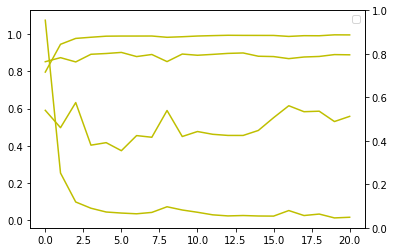

In [8]:
input = Input(shape=(200, 200, 3))

# include_top = fully connected layer(FC)
model = InceptionV3(input_tensor=input, include_top=False, weights='imagenet', pooling='max')

# 불러온 model은 학습시키기 않고 고정함
for layer in model.layers:
  layer.trainable = False

# fully connected layer(FC) 재구성
x = model.output

x = Dense(1024, name='fully', kernel_initializer="uniform")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(512, kernel_initializer='uniform')(x)
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)

x = Dense(101, activation='softmax', name='softmax')(x)

# model input, output 연결
model = Model(model.input, x)

# model.summary()

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # rgb를 0~1 값으로 변경, train : val = 8:2
batch_size = 16
input_image_size = (200, 200)

# train data 준비
train_generator = train_datagen.flow_from_directory(
    '/drive/My Drive/Dataset/caltech101',
    target_size=input_image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
) 

# validation data 준비
validation_generator = train_datagen.flow_from_directory(
    '/drive/My Drive/Dataset/caltech101',
    target_size=input_image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
) 


model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

# val_acc가 15회 변화가 없을 때 자동 종료
early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_acc')

# 학습 대상 설정
hist = model.fit(train_generator,
                 steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                 validation_data=validation_generator,
                 epochs=100,
                 callbacks=[early_stopping])

# 시각화
import matplotlib
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.plot(hist.history['acc'], 'y', label='train acc')
loss_ax.plot(hist.history['val_acc'], 'y', label='validation acc')

plt.legend(['train acc', 'validation acc'])
plt.show()